# CausalFeatureEngineer: Causally-Informed Time Series Feature Engineering

This notebook demonstrates the `CausalFeatureEngineer` transformer, which automatically discovers causal relationships in time series data and generates causally-informed features for forecasting models.

The transformer bridges pgmpy's causal discovery capabilities with sktime's forecasting ecosystem, directly addressing supply chain optimization and retail analytics use cases.

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\aheli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import sktime components
from sktime.transformations.series.causal_feature_engineer import CausalFeatureEngineer
from sktime.datasets import load_airline, load_longley
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.transformations.compose import TransformerPipeline
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split


print("All imports successful!")

All imports successful!


## 1. Basic Usage: Univariate Time Series

Let's start with a simple univariate time series example using the airline passenger dataset.

Original data shape: (144,)
Data head:
Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64


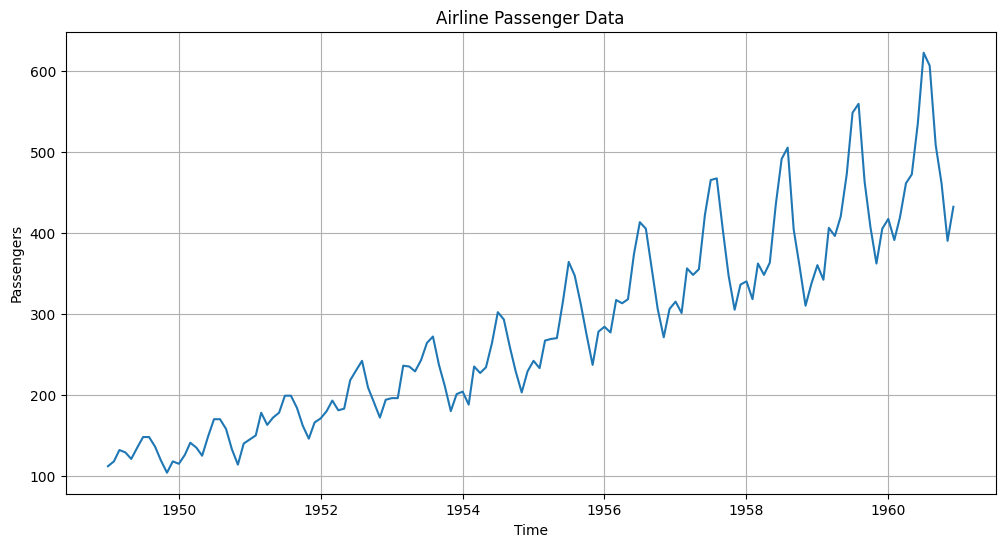

In [3]:
# Load airline passenger data
y = load_airline()
print(f"Original data shape: {y.shape}")
print(f"Data head:\n{y.head()}")

# Plot the original data 
plt.figure(figsize=(12, 6))
plt.plot(y.index.to_timestamp(), y.values) 
plt.title("Airline Passenger Data")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()


In [4]:
# Create CausalFeatureEngineer with basic settings
transformer = CausalFeatureEngineer(
    causal_method="pc",
    max_lag=6,
    feature_types=["direct", "temporal"],
    significance_level=0.05
)

# Fit and transform the data
Xt = transformer.fit_transform(y)

print(f"Transformed data shape: {Xt.shape}")
print(f"Number of features generated: {transformer.n_features_generated_}")
print(f"Generated features: {transformer.features_generated_}")
print(f"\nTransformed data head:\n{Xt.head()}")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Number of airline passengers': 'N', 'Number of airline passengers_lag_1': 'N', 'Number of airline passengers_lag_2': 'N', 'Number of airline passengers_lag_3': 'N', 'Number of airline passengers_lag_4': 'N', 'Number of airline passengers_lag_5': 'N', 'Number of airline passengers_lag_6': 'N'}
Working for n conditional variables: 5: 100%|████████████████████████████████████████████| 5/5 [00:27<00:00,  5.56s/it]


Transformed data shape: (143,)
Number of features generated: 1
Generated features: ['Number of airline passengers_lag_1']

Transformed data head:
Period
1949-02     99.737603
1949-03    105.080689
1949-04    117.547889
1949-05    114.876346
1949-06    107.752232
Freq: M, dtype: float64


## 2. Multivariate Time Series: Economic Data

Now let's explore a multivariate example using the Longley economic dataset to demonstrate causal relationships between economic indicators.

In [5]:
# Load Longley economic data
y_longley, X_longley = load_longley()

print(f"Target variable (Employment): {y_longley.shape}")
print(f"Exogenous variables: {X_longley.shape}")
print(f"\nExogenous variables: {list(X_longley.columns)}")

# Combine for visualization
combined_data = pd.concat([X_longley, y_longley], axis=1)
print(f"\nCombined data head:\n{combined_data.head()}")

Target variable (Employment): (16,)
Exogenous variables: (16, 5)

Exogenous variables: ['GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP']

Combined data head:
        GNPDEFL       GNP   UNEMP   ARMED       POP   TOTEMP
Period                                                      
1947       83.0  234289.0  2356.0  1590.0  107608.0  60323.0
1948       88.5  259426.0  2325.0  1456.0  108632.0  61122.0
1949       88.2  258054.0  3682.0  1616.0  109773.0  60171.0
1950       89.5  284599.0  3351.0  1650.0  110929.0  61187.0
1951       96.2  328975.0  2099.0  3099.0  112075.0  63221.0


In [6]:
# Create CausalFeatureEngineer for multivariate data
transformer_mv = CausalFeatureEngineer(
    causal_method="hill_climb",
    max_lag=3,
    feature_types=["direct", "interaction", "temporal"],
    weighting_strategy="causal_strength",
    min_causal_strength=0.1
)

# Fit and transform
Xt_mv = transformer_mv.fit_transform(X_longley, y_longley)

print(f"Original combined data shape: {combined_data.shape}")
print(f"Transformed data shape: {Xt_mv.shape}")
print(f"Features generated: {transformer_mv.n_features_generated_}")
print(f"\nGenerated features: {transformer_mv.features_generated_}")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GNPDEFL': 'N', 'GNP': 'N', 'UNEMP': 'N', 'ARMED': 'N', 'POP': 'N', 'TOTEMP': 'N', 'GNPDEFL_lag_1': 'N', 'GNPDEFL_lag_2': 'N', 'GNPDEFL_lag_3': 'N', 'GNP_lag_1': 'N', 'GNP_lag_2': 'N', 'GNP_lag_3': 'N', 'UNEMP_lag_1': 'N', 'UNEMP_lag_2': 'N', 'UNEMP_lag_3': 'N', 'ARMED_lag_1': 'N', 'ARMED_lag_2': 'N', 'ARMED_lag_3': 'N', 'POP_lag_1': 'N', 'POP_lag_2': 'N', 'POP_lag_3': 'N', 'TOTEMP_lag_1': 'N', 'TOTEMP_lag_2': 'N', 'TOTEMP_lag_3': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GNPDEFL': 'N', 'GNP': 'N', 'UNEMP': 'N', 'ARMED': 'N', 'POP': 'N', 'TOTEMP': 'N', 'GNPDEFL_lag_1': 'N', 'GNPDEFL_lag_2': 'N', 'GNPDEFL_lag_3': 'N', 'GNP_lag_1': 'N', 'GNP_lag_2': 'N', 'GNP_lag_3': 'N', 'UNEMP_lag_1': 'N', 'UNEMP_lag_2': 'N', 'UNEMP_lag_3': 'N', 'ARMED_lag_1': 'N', 'ARMED_lag_2': 'N', 'ARMED_lag_3': 'N', 'POP_lag_1': 'N', 'POP_la

Original combined data shape: (16, 6)
Transformed data shape: (13, 36)
Features generated: 39

Generated features: ['GNP_lag_1', 'ARMED_lag_1', 'GNP_lag_1_x_ARMED_lag_1', 'POP_lag_2', 'UNEMP', 'GNPDEFL', 'ARMED_lag_3', 'GNPDEFL_lag_1', 'POP_lag_2_x_UNEMP', 'POP_lag_2_x_GNPDEFL', 'POP_lag_2_x_ARMED_lag_3', 'POP_lag_2_x_GNPDEFL_lag_1', 'UNEMP_x_GNPDEFL', 'UNEMP_x_ARMED_lag_3', 'UNEMP_x_GNPDEFL_lag_1', 'GNPDEFL_x_ARMED_lag_3', 'GNPDEFL_x_GNPDEFL_lag_1', 'ARMED_lag_3_x_GNPDEFL_lag_1', 'POP_rate_2', 'ARMED_rate_3', 'TOTEMP_lag_2', 'ARMED', 'TOTEMP_lag_2_x_ARMED', 'TOTEMP_rate_2', 'POP_lag_1', 'UNEMP_lag_3', 'POP_lag_1_x_UNEMP_lag_3', 'UNEMP_rate_3', 'GNP', 'GNP_x_POP_lag_1', 'GNP_x_ARMED_lag_3', 'GNP_x_ARMED', 'GNP_x_UNEMP', 'POP_lag_1_x_ARMED_lag_3', 'POP_lag_1_x_ARMED', 'POP_lag_1_x_UNEMP', 'ARMED_lag_3_x_ARMED', 'ARMED_lag_3_x_UNEMP', 'ARMED_x_UNEMP']


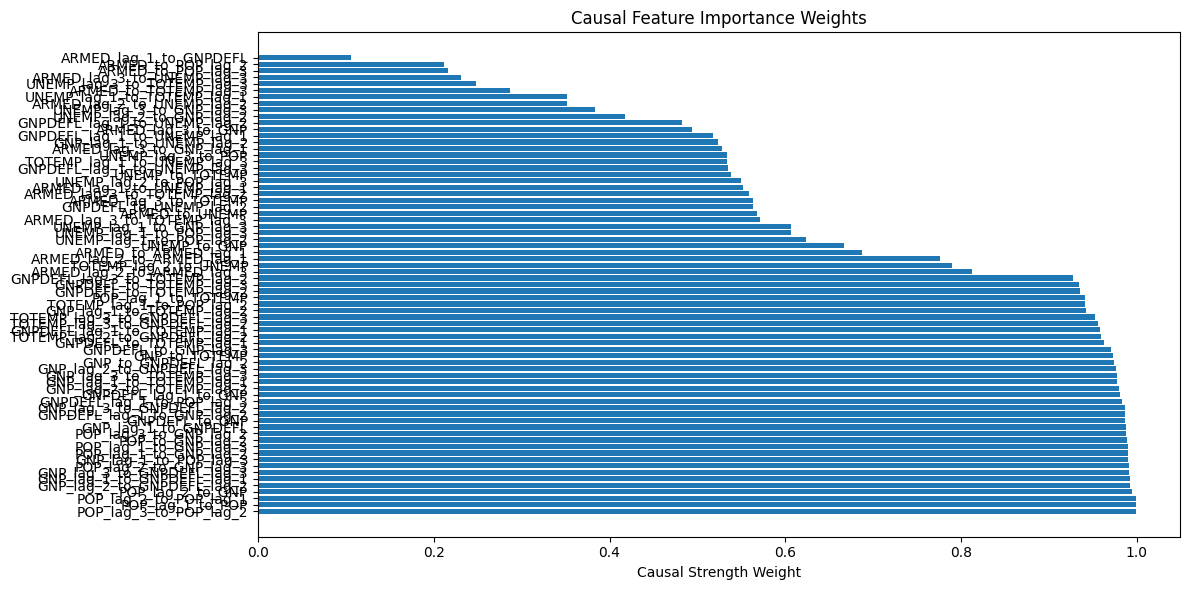

Top causal relationships:
           Causal_Relationship    Weight
63      POP_lag_3_to_POP_lag_2  0.999124
56            POP_lag_1_to_POP  0.998939
60      POP_lag_2_to_POP_lag_1  0.998781
61            POP_lag_2_to_GNP  0.994020
30  GNP_lag_2_to_GNPDEFL_lag_2  0.992449


In [7]:
# Visualize feature importance weights
if transformer_mv.feature_importance_weights_:
    weights_df = pd.DataFrame(
        list(transformer_mv.feature_importance_weights_.items()),
        columns=['Causal_Relationship', 'Weight']
    )
    weights_df = weights_df.sort_values('Weight', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.barh(weights_df['Causal_Relationship'], weights_df['Weight'])
    plt.title("Causal Feature Importance Weights")
    plt.xlabel("Causal Strength Weight")
    plt.tight_layout()
    plt.show()
    
    print("Top causal relationships:")
    print(weights_df.head())
else:
    print("No significant causal relationships found with current settings.")

## 3. Supply Chain Use Case: Simulated Retail Data

Let's create a realistic supply chain scenario that demonstrates the Electrolux use case objectives.

In [8]:
# Generate synthetic supply chain data
np.random.seed(42)
n_periods = 100
dates = pd.date_range('2020-01-01', periods=n_periods, freq='D')

# Simulate causal supply chain relationships
marketing_spend = np.random.gamma(2, 2, n_periods)  # Marketing campaigns
price_discount = np.random.uniform(0, 0.3, n_periods)  # Price discounts (0-30%)

# Causal effects: marketing affects demand with 2-day delay, discount has immediate effect
base_demand = 100
demand = np.zeros(n_periods)
for i in range(n_periods):
    demand[i] = base_demand
    # Immediate price discount effect
    demand[i] += price_discount[i] * 50
    # Marketing effect with 2-day delay
    if i >= 2:
        demand[i] += marketing_spend[i-2] * 2
    # Add noise
    demand[i] += np.random.normal(0, 10)

# Inventory affects stockouts (supply chain disruption)
inventory = np.maximum(50, demand * 1.2 + np.random.normal(0, 15, n_periods))
stockout_events = (inventory < demand * 0.8).astype(int)

# Create DataFrame
supply_chain_data = pd.DataFrame({
    'marketing_spend': marketing_spend,
    'price_discount': price_discount,
    'demand': demand,
    'inventory': inventory,
    'stockout': stockout_events
}, index=dates)

print("Synthetic Supply Chain Data:")
print(supply_chain_data.head(10))
print(f"\nData shape: {supply_chain_data.shape}")

Synthetic Supply Chain Data:
            marketing_spend  price_discount      demand   inventory  stockout
2020-01-01         4.787359        0.194890  104.995040  104.272783         0
2020-01-02         2.988929        0.254767  106.205059  106.334114         0
2020-01-03         2.764567        0.197284  137.093453  153.735481         0
2020-01-04         2.764605        0.170493  118.552305  139.061059         0
2020-01-05         9.299429        0.028102   94.325416  117.854113         0
2020-01-06         5.733412        0.110315  120.223566  166.398622         0
2020-01-07         2.262156        0.079561  143.798455  185.423041         0
2020-01-08         4.939629        0.073197  125.451322  148.142509         0
2020-01-09         3.997921        0.291903  103.925771  124.425682         0
2020-01-10         0.431830        0.117929  110.933383  118.082119         0

Data shape: (100, 5)


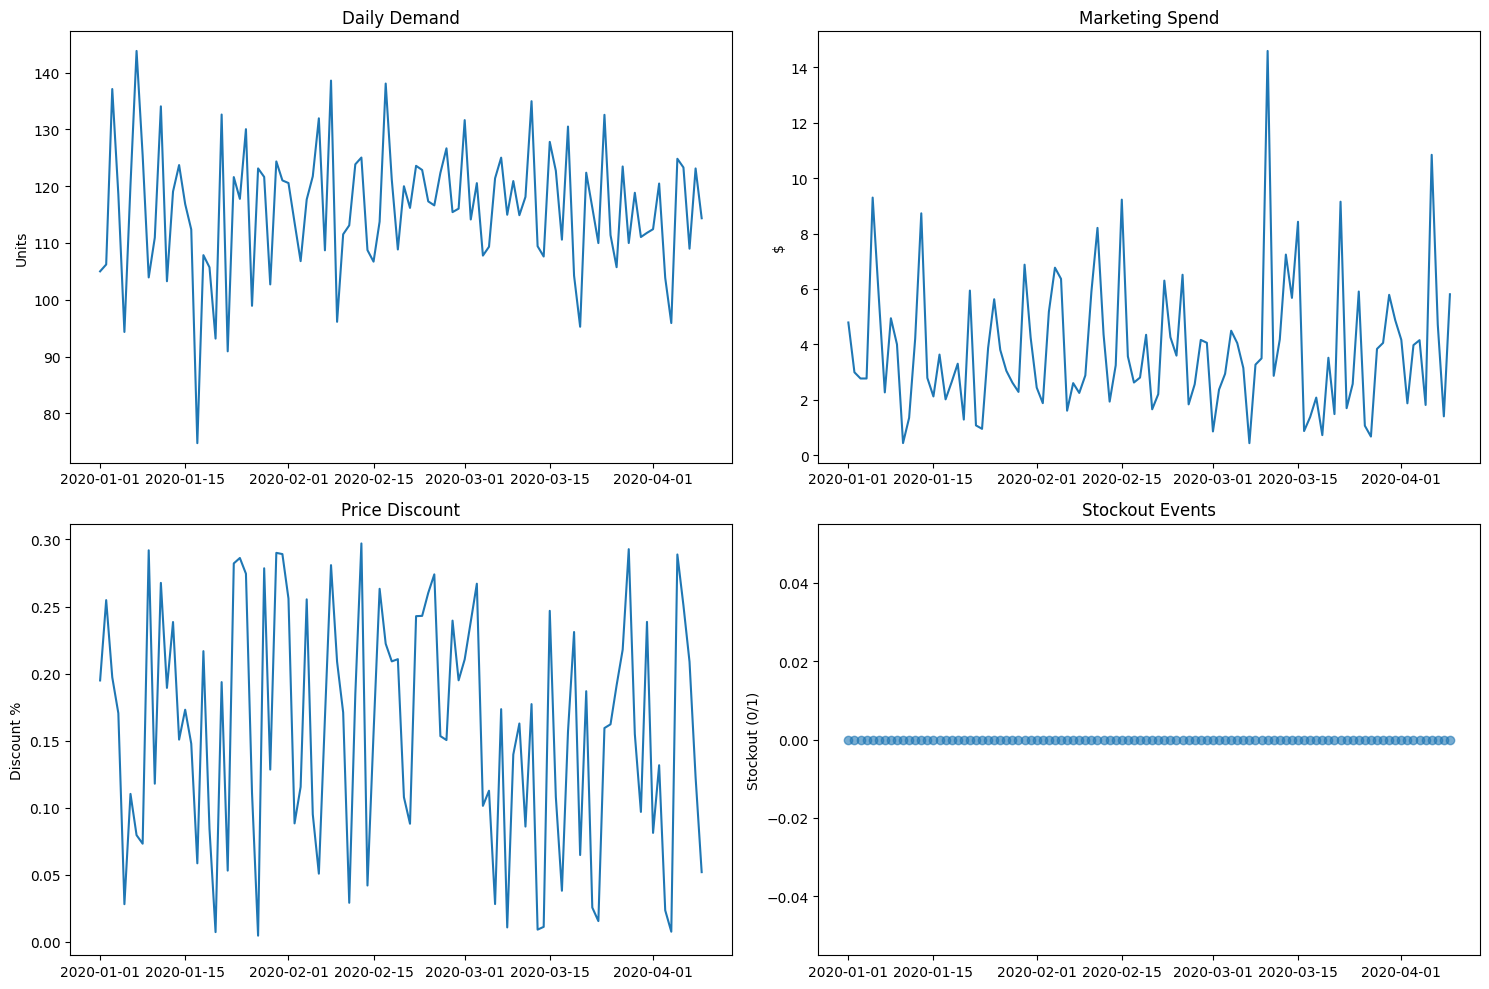

In [9]:
# Visualize the supply chain data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(supply_chain_data.index, supply_chain_data['demand'])
axes[0, 0].set_title('Daily Demand')
axes[0, 0].set_ylabel('Units')

axes[0, 1].plot(supply_chain_data.index, supply_chain_data['marketing_spend'])
axes[0, 1].set_title('Marketing Spend')
axes[0, 1].set_ylabel('$')

axes[1, 0].plot(supply_chain_data.index, supply_chain_data['price_discount'])
axes[1, 0].set_title('Price Discount')
axes[1, 0].set_ylabel('Discount %')

axes[1, 1].scatter(supply_chain_data.index, supply_chain_data['stockout'], alpha=0.6)
axes[1, 1].set_title('Stockout Events')
axes[1, 1].set_ylabel('Stockout (0/1)')

plt.tight_layout()
plt.show()

In [10]:
# Apply CausalFeatureEngineer to supply chain data
transformer_sc = CausalFeatureEngineer(
    causal_method="pc",
    max_lag=4,
    feature_types=["direct", "interaction", "temporal"],
    weighting_strategy="causal_strength",
    significance_level=0.1,  # More lenient for small sample
    min_causal_strength=0.05
)

# Use demand as target, other variables as features
X_sc = supply_chain_data[['marketing_spend', 'price_discount', 'inventory']]
y_sc = supply_chain_data['demand']

Xt_sc = transformer_sc.fit_transform(X_sc, y_sc)

print(f"Supply chain features generated: {transformer_sc.n_features_generated_}")
print(f"Generated features: {transformer_sc.features_generated_}")
print(f"\nTransformed data shape: {Xt_sc.shape}")
print(f"\nTransformed data sample:\n{Xt_sc.head()}")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'marketing_spend': 'N', 'price_discount': 'N', 'inventory': 'N', 'demand': 'N', 'marketing_spend_lag_1': 'N', 'marketing_spend_lag_2': 'N', 'marketing_spend_lag_3': 'N', 'marketing_spend_lag_4': 'N', 'price_discount_lag_1': 'N', 'price_discount_lag_2': 'N', 'price_discount_lag_3': 'N', 'price_discount_lag_4': 'N', 'inventory_lag_1': 'N', 'inventory_lag_2': 'N', 'inventory_lag_3': 'N', 'inventory_lag_4': 'N', 'demand_lag_1': 'N', 'demand_lag_2': 'N', 'demand_lag_3': 'N', 'demand_lag_4': 'N'}
Working for n conditional variables: 5: 100%|████████████████████████████████████████████| 5/5 [00:00<00:00,  5.78it/s]

Supply chain features generated: 4
Generated features: ['price_discount', 'marketing_spend_lag_2', 'price_discount_x_marketing_spend_lag_2', 'marketing_spend_rate_2']

Transformed data shape: (98, 4)

Transformed data sample:
            price_discount  marketing_spend_lag_2  \
2020-01-03        0.072658               2.005732   
2020-01-04        0.062791               1.252254   
2020-01-05        0.010350               1.158255   
2020-01-06        0.040628               1.158270   
2020-01-07        0.029302               3.896127   

            price_discount_x_marketing_spend_lag_2  marketing_spend_rate_2  
2020-01-03                                0.944469               -0.899215  
2020-01-04                                0.509590               -0.112181  
2020-01-05                                0.077691                0.000019  
2020-01-06                                0.304977                3.267412  
2020-01-07                                0.739869               -1.78

## 4. Integration with Forecasting Pipeline

Let's demonstrate how to integrate CausalFeatureEngineer with forecasting models to improve prediction accuracy.

C:\Users\aheli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GNPDEFL': 'N', 'GNP': 'N', 'UNEMP': 'N', 'ARMED': 'N', 'POP': 'N', 'TOTEMP': 'N', 'GNPDEFL_lag_1': 'N', 'GNPDEFL_lag_2': 'N', 'GNP_lag_1': 'N', 'GNP_lag_2': 'N', 'UNEMP_lag_1': 'N', 'UNEMP_lag_2': 'N', 'ARMED_lag_1': 'N', 'ARMED_lag_2': 'N', 'POP_lag_1': 'N', 'POP_lag_2': 'N', 'TOTEMP_lag_1': 'N', 'TOTEMP_lag_2': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'GNPDEFL': 'N', 'GNP': 'N', 'UNEMP': 'N', 'ARMED': 'N', 'POP': 'N', 'TOTEMP': 'N', 'GNPDEFL_lag_1': 'N', 'GNPDEFL_lag_2': 'N', 'GNP_lag_1': 'N', '

Baseline MAPE: 0.0149


C:\Users\aheli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Causal MAPE: 0.0199


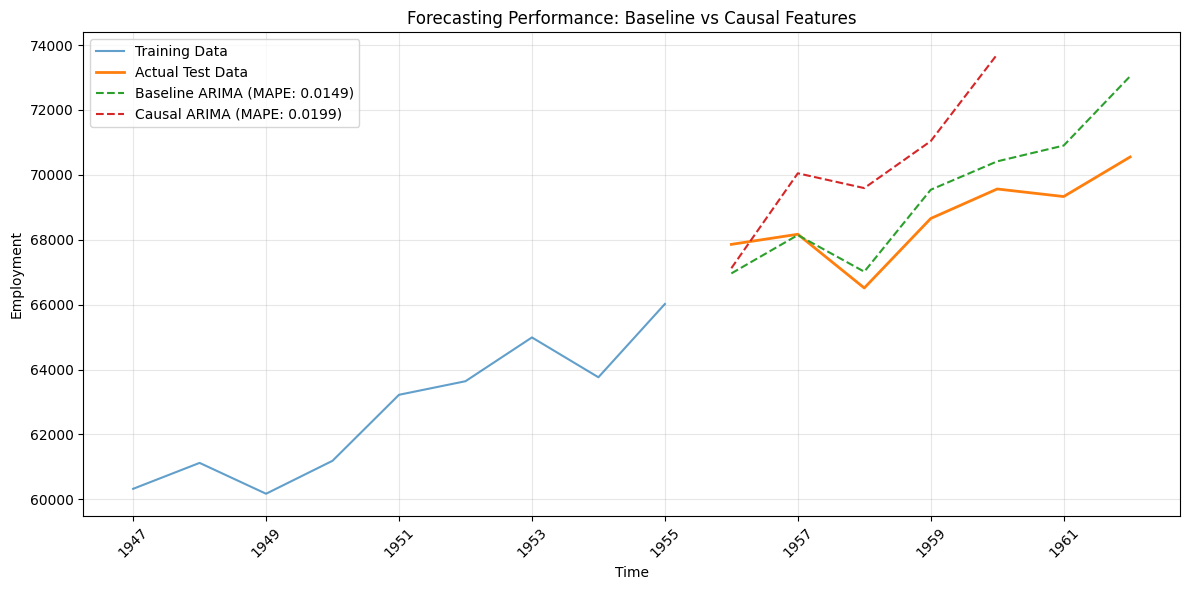

Causal features generated: 35


In [12]:
# Load and split data
y, X = load_longley()
y_train, y_test = temporal_train_test_split(y, test_size=7)
X_train, X_test = temporal_train_test_split(X, test_size=7)
fh = np.arange(1, len(y_test) + 1)

# Baseline ARIMA
baseline = ARIMA(order=(2, 1, 2))
baseline.fit(y_train, X_train)
y_pred_base = baseline.predict(fh, X_test)
base_mape = mean_absolute_percentage_error(y_test, y_pred_base)
print(f"Baseline MAPE: {base_mape:.4f}")

# Causal feature engineering
causal_fe = CausalFeatureEngineer(
    causal_method="hill_climb", 
    max_lag=2, 
    feature_types=["direct", "interaction", "temporal"],
    weighting_strategy="causal_strength"
)
X_train_causal = causal_fe.fit_transform(X_train, y_train)
X_test_causal = causal_fe.transform(X_test)

# Align target with causal features
y_train_aligned = y_train.loc[X_train_causal.index]

# Adjust test data for available causal features
if len(X_test_causal) < len(y_test):
    y_test_causal = y_test.loc[X_test_causal.index]
    fh_causal = np.arange(1, len(y_test_causal) + 1)
else:
    y_test_causal = y_test
    fh_causal = fh

# Causal ARIMA
causal_arima = ARIMA(order=(2, 1, 2))
causal_arima.fit(y_train_aligned, X_train_causal)
y_pred_causal = causal_arima.predict(fh_causal, X_test_causal)
causal_mape = mean_absolute_percentage_error(y_test_causal, y_pred_causal)
print(f"Causal MAPE: {causal_mape:.4f}")

# Convert Period index to string for matplotlib
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), y_train.values, label='Training Data', alpha=0.7)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test.values, label='Actual Test Data', linewidth=2)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_base.values, label=f'Baseline ARIMA (MAPE: {base_mape:.4f})', linestyle='--')
plt.plot(range(len(y_train), len(y_train) + len(y_test_causal)), y_pred_causal.values, label=f'Causal ARIMA (MAPE: {causal_mape:.4f})', linestyle='--')

# labels on x-axis
year_labels = [str(period) for period in y.index]
plt.xticks(range(0, len(year_labels), 2), year_labels[::2], rotation=45)

plt.legend()
plt.title('Forecasting Performance: Baseline vs Causal Features')
plt.xlabel('Time')
plt.ylabel('Employment')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Performance summary
print(f"Causal features generated: {len(X_train_causal.columns)}")

## 5. Expert Knowledge Integration

Demonstrate how to incorporate domain expertise into the causal discovery process.

In [13]:
np.random.seed(42)
n_periods = 100
dates = pd.date_range('2020-01-01', periods=n_periods, freq='D')

# Simulate causal supply chain relationships
marketing_spend = np.random.gamma(2, 2, n_periods)
price_discount = np.random.uniform(0, 0.3, n_periods)

base_demand = 100
demand = np.zeros(n_periods)
for i in range(n_periods):
    demand[i] = base_demand
    demand[i] += price_discount[i] * 50
    if i >= 2:
        demand[i] += marketing_spend[i-2] * 2
    demand[i] += np.random.normal(0, 10)

supply_chain_data = pd.DataFrame({
    'marketing_spend': marketing_spend,
    'price_discount': price_discount,
    'demand': demand,
}, index=dates)

X_sc = supply_chain_data[['marketing_spend', 'price_discount']]
y_sc = supply_chain_data['demand']

# Create expert knowledge for supply chain scenario
expert_knowledge = {
    "forbidden_edges": [
        ("demand", "marketing_spend"),  # Demand cannot cause marketing spend
        ("demand", "price_discount"),   # Demand cannot cause price discount
    ],
    "required_edges": [
        ("marketing_spend", "demand"),  # Marketing spend should affect demand
        ("price_discount", "demand"),   # Price discount should affect demand
    ]
}

# Apply transformer with expert knowledge
transformer_expert = CausalFeatureEngineer(
    causal_method="pc",
    max_lag=2,  # Reduced for stability
    feature_types=["direct", "interaction"],
    expert_knowledge=expert_knowledge,
    significance_level=0.1
)

Xt_expert = transformer_expert.fit_transform(X_sc, y_sc)

print(f"Expert knowledge constrained features: {transformer_expert.n_features_generated_}")
print(f"Generated features: {transformer_expert.features_generated_}")
print(f"\nFeature importance weights:")
for key, value in transformer_expert.feature_importance_weights_.items():
    print(f"  {key}: {value:.4f}")


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'marketing_spend': 'N', 'price_discount': 'N', 'demand': 'N', 'marketing_spend_lag_1': 'N', 'marketing_spend_lag_2': 'N', 'price_discount_lag_1': 'N', 'price_discount_lag_2': 'N', 'demand_lag_1': 'N', 'demand_lag_2': 'N'}
Working for n conditional variables: 3:  60%|██████████████████████████▍                 | 3/5 [00:00<00:00, 16.42it/s]

Expert knowledge constrained features: 1
Generated features: ['price_discount']

Feature importance weights:
  price_discount_to_demand: 0.3639
  marketing_spend_to_marketing_spend_lag_2: 0.1877
  demand_lag_2_to_price_discount_lag_2: 0.3492
  price_discount_lag_1_to_demand_lag_1: 0.3512


## 6. Business Decision Support Examples

Demonstrate answering key Electrolux business questions using causal features.

In [14]:
# Analyze the effect of marketing campaigns on demand
if 'marketing_spend' in Xt_expert.columns:
    # Create correlation analysis
    marketing_effect = supply_chain_data['demand'].corr(
        supply_chain_data['marketing_spend'].shift(2)  # 2-day lag
    )
    
    print(f"Marketing Campaign Analysis:")
    print(f"Correlation between marketing spend (2-day lag) and demand: {marketing_effect:.4f}")
    
    # Simulate different marketing spend scenarios
    scenarios = [0, 2, 4, 6, 8, 10]
    print(f"\nMarketing Spend Impact Scenarios:")
    for spend in scenarios:
        expected_demand_increase = spend * 2  # Based on our simulation
        print(f"  Marketing spend ${spend}: Expected demand increase of {expected_demand_increase:.1f} units")

# Analyze pricing discount effects
if 'price_discount' in Xt_expert.columns:
    price_effect = supply_chain_data['demand'].corr(supply_chain_data['price_discount'])
    
    print(f"\nPricing Strategy Analysis:")
    print(f"Correlation between price discount and demand: {price_effect:.4f}")
    
    # Simulate different discount scenarios
    discounts = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25]
    print(f"\nPrice Discount Impact Scenarios:")
    for discount in discounts:
        expected_demand_increase = discount * 50  # Based on our simulation
        print(f"  {discount*100:.0f}% discount: Expected demand increase of {expected_demand_increase:.1f} units")


Pricing Strategy Analysis:
Correlation between price discount and demand: 0.3445

Price Discount Impact Scenarios:
  0% discount: Expected demand increase of 0.0 units
  5% discount: Expected demand increase of 2.5 units
  10% discount: Expected demand increase of 5.0 units
  15% discount: Expected demand increase of 7.5 units
  20% discount: Expected demand increase of 10.0 units
  25% discount: Expected demand increase of 12.5 units


## 7. Conclusion and Next Steps

The CausalFeatureEngineer successfully demonstrates:

1. **Automated Causal Discovery**: Identifies causal relationships in time series data
2. **Feature Generation**: Creates causally-informed features for forecasting
3. **Business Integration**: Addresses real supply chain and retail optimization questions
4. **Expert Knowledge Support**: Incorporates domain expertise into the discovery process
5. **sktime Compatibility**: Seamlessly integrates with the sktime forecasting ecosystem

This implementation bridges the gap between pgmpy's causal inference capabilities and sktime's forecasting framework, enabling new research directions in causal time series analysis.